In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage, Compose, Normalize, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip
from PIL import Image
import os
import glob
import numpy as np
import math
from tqdm import tqdm
import cv2 
import sys
import time
import subprocess 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CONFIG = {
    "data_root": "/kaggle/input/dlp-jan-2025-nppe-3/archive",
    "output_dir": "/kaggle/working/output_unet", 
    "test_output_dir": "/kaggle/working/submission_images_unet",
    "model_save_name": "unet_sr_model.pth", # New model name
    "epochs": 150, # Adjust based on convergence
    "batch_size": 8, # U-Nets might be less memory hungry than SwinIR
    "learning_rate": 1e-4, # Starting LR (MSE loss values can be small)
    "num_workers": 2,
    "seed": 42,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    "upscale_factor": 4,
    "train_patch_size": 64, # LR patch size for training
    "unet_init_features": 32, # Number of channels after first layer (adjust for lighter/heavier)
}

In [3]:
os.makedirs(CONFIG["output_dir"], exist_ok=True)
os.makedirs(CONFIG["test_output_dir"], exist_ok=True)

# Set random seed
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG["seed"])


In [4]:
def calculate_psnr(img1, img2, border=0):
    if not isinstance(img1, np.ndarray): img1 = np.array(img1)
    if not isinstance(img2, np.ndarray): img2 = np.array(img2)
    if img1.dtype != np.uint8: img1 = img1.clip(0, 255).astype(np.uint8)
    if img2.dtype != np.uint8: img2 = img2.clip(0, 255).astype(np.uint8)
    if border > 0:
        img1 = img1[border:-border, border:-border, ...]
        img2 = img2[border:-border, border:-border, ...]
    mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64)) ** 2)
    if mse == 0: return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


In [21]:
def visualize_imgs(dataloader, num_samples=5):
    for i, (lr_img, hr_img) in enumerate(dataloader):
        if i >= num_samples:
            break
                
        device = CONFIG["device"]
        lr_img, hr_img = lr_img.to(device), hr_img.to(device)
        
        # Convert tensors to numpy arrays
        lr_img = lr_img[0].cpu().numpy().transpose(1, 2, 0)
        hr_img = hr_img[0].cpu().numpy().transpose(1, 2, 0)
    
    
        # Clip values to [0, 1]
        lr_img = np.clip(lr_img, 0, 1)
        hr_img = np.clip(hr_img, 0, 1)
    
    
        # Plot
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Low Resolution")
        plt.imshow(lr_img)
        plt.axis('off')
    
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(hr_img)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()


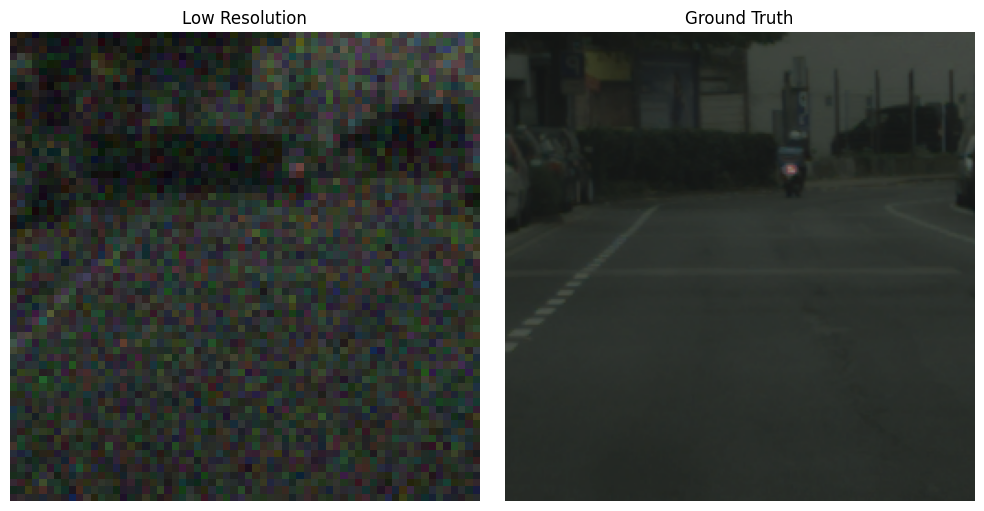

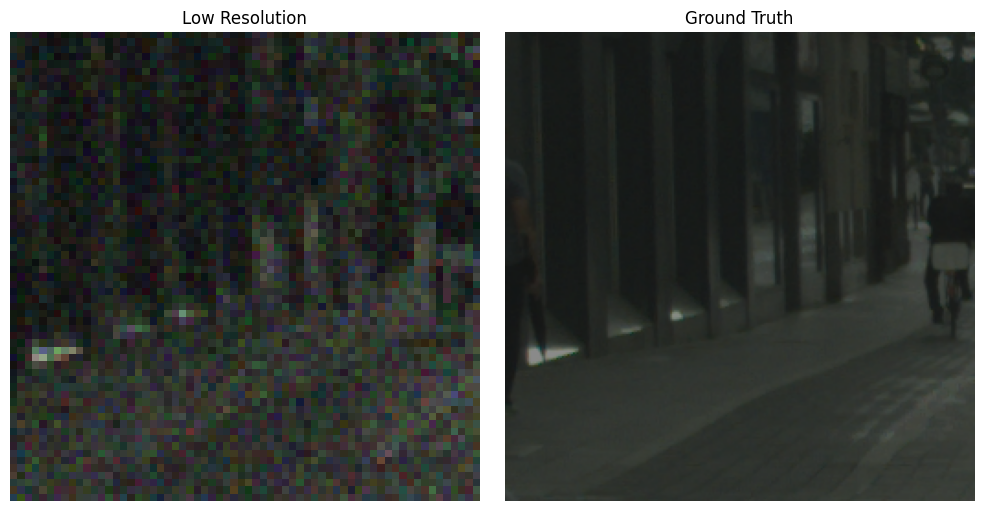

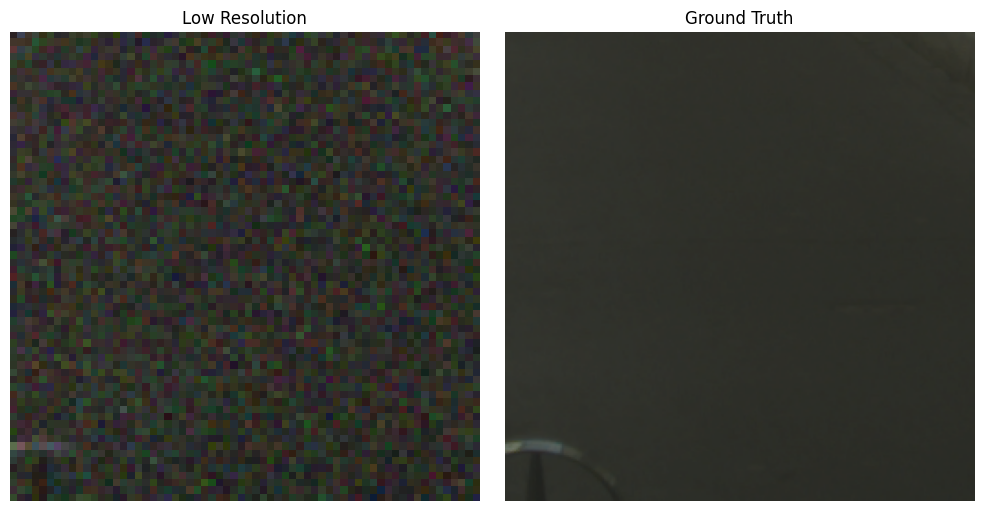

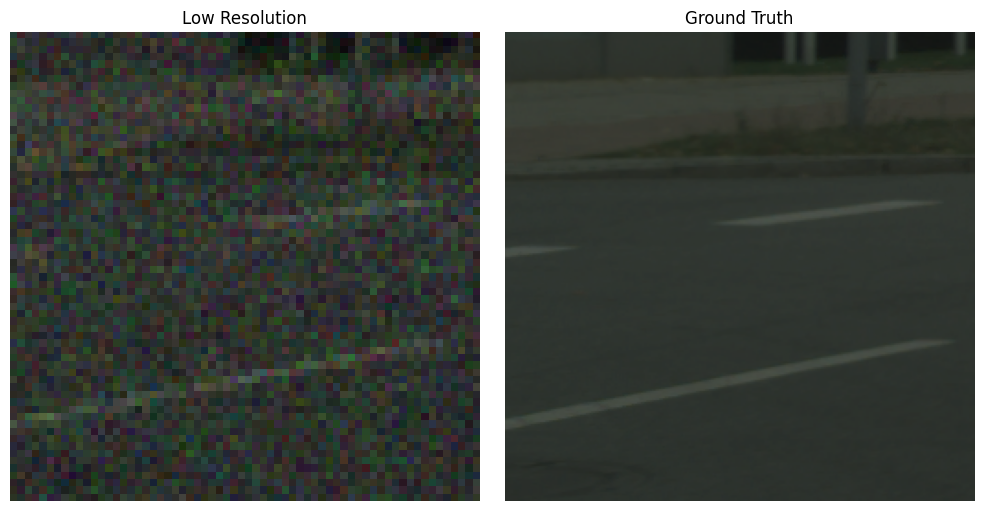

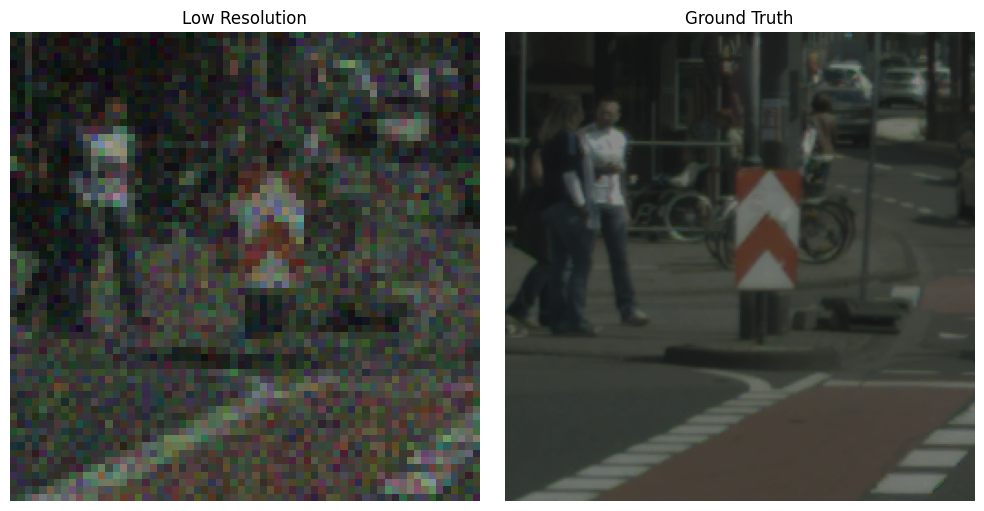

In [24]:
visualize_imgs(train_loader)

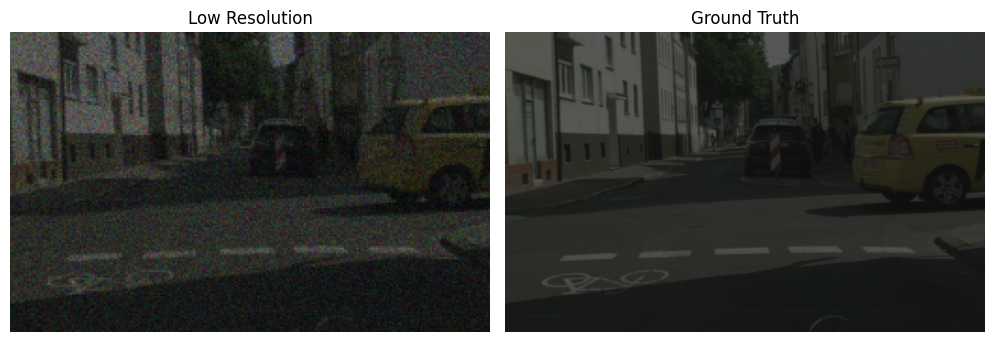

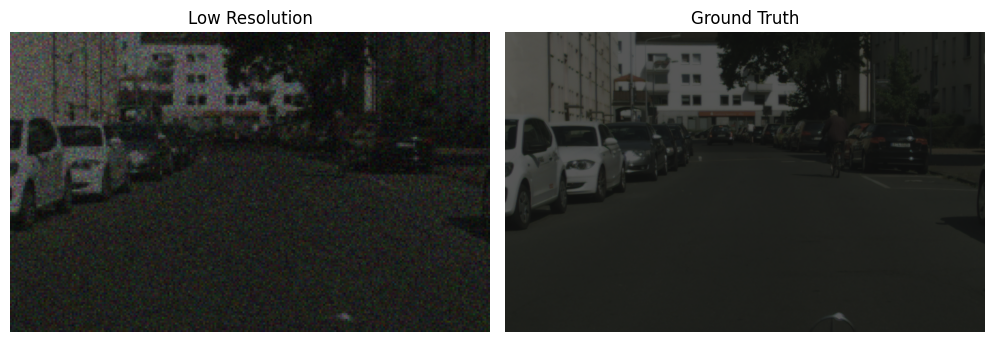

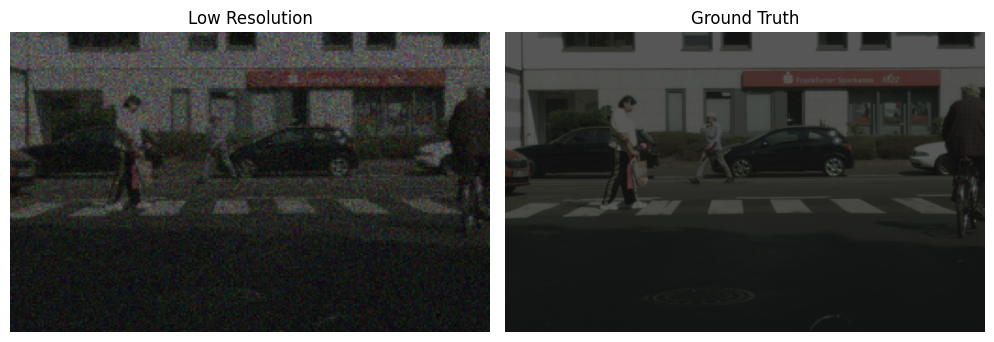

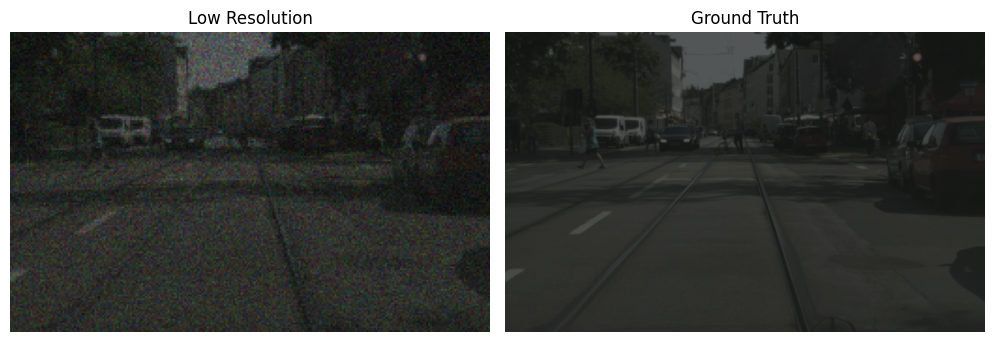

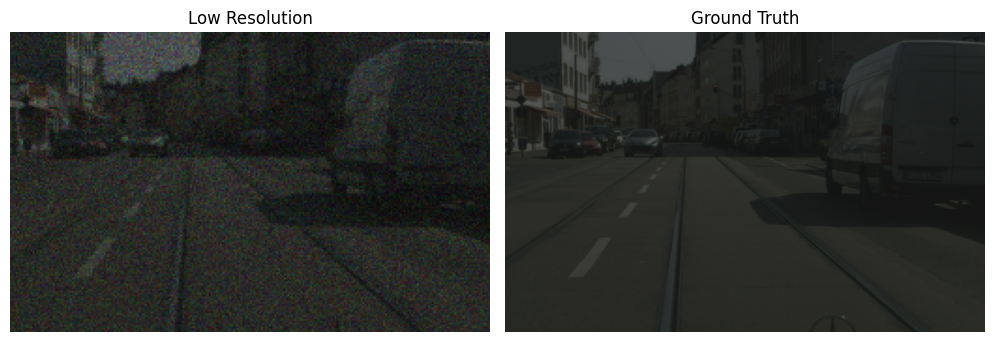

In [25]:
visualize_imgs(val_loader)

In [6]:
class ImageDataset(Dataset):
    @staticmethod
    def _make_key(fname):
        # strip off anything before the first underscore, if present
        return fname.split('_', 1)[-1]

    def __init__(self, lr_dir, hr_dir, image_size, upscale_factor, is_train=True):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.image_size = image_size
        self.upscale_factor = upscale_factor
        self.hr_image_size = image_size * upscale_factor
        self.is_train = is_train

        # Build HR lookup: key → full path
        self.hr_image_files = {}
        for hr_path in glob.glob(os.path.join(hr_dir, '*.*')):
            key = self._make_key(os.path.basename(hr_path))
            self.hr_image_files[key] = hr_path

        # Collect LR files whose key exists in HR
        all_lr = sorted(glob.glob(os.path.join(lr_dir, '*.*')))
        self.lr_image_files = []
        for lr_path in all_lr:
            key = self._make_key(os.path.basename(lr_path))
            if key in self.hr_image_files:
                self.lr_image_files.append(lr_path)

        self.transform = ToTensor()

    def __len__(self):
        return len(self.lr_image_files)

    def __getitem__(self, idx):
        lr_path = self.lr_image_files[idx]
        key     = self._make_key(os.path.basename(lr_path))
        hr_path = self.hr_image_files[key]

        # load
        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')
        lr = self.transform(lr_img)
        hr = self.transform(hr_img)

        if self.is_train:
            # random crop
            lh, lw = lr.shape[1:]
            if lh < self.image_size or lw < self.image_size:
                lr = F.interpolate(lr.unsqueeze(0),
                                   size=(self.image_size, self.image_size),
                                   mode='bicubic', align_corners=False
                                  ).squeeze(0)
                hr = F.interpolate(hr.unsqueeze(0),
                                   size=(self.hr_image_size, self.hr_image_size),
                                   mode='bicubic', align_corners=False
                                  ).squeeze(0)
                top, left = 0, 0
            else:
                top  = torch.randint(0, lh - self.image_size + 1, (1,)).item()
                left = torch.randint(0, lw - self.image_size + 1, (1,)).item()
                lr   = lr[:, top:top+self.image_size, left:left+self.image_size]
                top_hr, left_hr = top * self.upscale_factor, left * self.upscale_factor
                hr   = hr[:, top_hr:top_hr+self.hr_image_size,
                             left_hr:left_hr+self.hr_image_size]

            # random horizontal flip
            if torch.rand(1) < 0.5:
                lr = torch.flip(lr, dims=[2])
                hr = torch.flip(hr, dims=[2])

        return lr, hr


class TestImageDataset(Dataset):
    def __init__(self, test_dir):
        self.test_dir = test_dir
        self.image_files = sorted(glob.glob(os.path.join(test_dir, '*.*')))
        self.transform = ToTensor()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)
        return img_tensor, os.path.basename(img_path)



print("Setting up DataLoaders...")

train_dataset = ImageDataset(
    # Reads Low-Res from train/train
    lr_dir=os.path.join(CONFIG["data_root"], "train", "train"),
    # Reads High-Res from train/gt
    hr_dir=os.path.join(CONFIG["data_root"], "train", "gt"),
    image_size=CONFIG["train_patch_size"],
    upscale_factor=CONFIG["upscale_factor"],
    is_train=True
)

val_dataset = ImageDataset(
    # Reads Low-Res from val/val
    lr_dir=os.path.join(CONFIG["data_root"], "val", "val"),
    # Reads High-Res from val/gt
    hr_dir=os.path.join(CONFIG["data_root"], "val", "gt"),
    image_size=CONFIG["train_patch_size"], # Using full images for validation
    upscale_factor=CONFIG["upscale_factor"],
    is_train=False
)

test_dataset = TestImageDataset(
    # Reads Low-Res from test
    test_dir=os.path.join(CONFIG["data_root"], "test")
)


print("  ▶  # train images:", len(train_dataset))
print("  ▶  # val   images:", len(val_dataset))
print("  ▶  # test   images:", len(test_dataset))

Setting up DataLoaders...
  ▶  # train images: 1105
  ▶  # val   images: 267
  ▶  # test   images: 60


In [7]:
def collate_fn(batch): # (Keep the exact same code as before)
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=True, drop_last=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=CONFIG["num_workers"])
print("DataLoaders ready.")

DataLoaders ready.


In [15]:
class ConvBlock(nn.Module):
    """Helper: Conv -> BatchNorm -> LeakyReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, bias=False) # Bias=False because using BN
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class UpsampleBlock(nn.Module):
    """Helper: PixelShuffle(2x) -> ConvBlock"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # PixelShuffle increases spatial dim by 2, decreases channels by 4
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=2)
        # Input channels to conv is in_channels // 4 (from PS) + skip_channels
        # The actual concatenation happens in the UNet forward pass
        self.conv = ConvBlock(in_channels // 4, out_channels) # Process after pixel shuffle (before concat)

    def forward(self, x):
        x = self.pixel_shuffle(x)
        # Concatenation with skip connection will happen outside this block
        # x = self.conv(x) # Conv happens after concat in U-Net forward
        return x

In [16]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super().__init__()
        f = init_features

        # Encoder Path
        self.enc1 = nn.Sequential(ConvBlock(in_channels, f), ConvBlock(f, f)) # Output: f x H x W
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: f x H/2 x W/2

        self.enc2 = nn.Sequential(ConvBlock(f, f*2), ConvBlock(f*2, f*2)) # Output: f*2 x H/2 x W/2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: f*2 x H/4 x W/4

        self.enc3 = nn.Sequential(ConvBlock(f*2, f*4), ConvBlock(f*4, f*4)) # Output: f*4 x H/4 x W/4
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # Output: f*4 x H/8 x W/8

        # Bottleneck
        self.bottleneck = nn.Sequential(ConvBlock(f*4, f*8), ConvBlock(f*8, f*8)) # Output: f*8 x H/8 x W/8

        # Decoder Path (with 2x PixelShuffle for 4x total upsampling)

        # Upsample 1 (-> H/4 x W/4) - Uses PixelShuffle internaly (requires *4 channels)
        self.up1_ps = nn.PixelShuffle(2) # f*8 -> f*2 channels, spatial H/4 x W/4
        self.dec1_conv = nn.Sequential(ConvBlock(f*2 + f*4, f*4), ConvBlock(f*4, f*4)) # Concat enc3(f*4)

        # Upsample 2 (-> H/2 x W/2)
        self.up2_ps = nn.PixelShuffle(2) # f*4 -> f*1 channels, spatial H/2 x W/2
        self.dec2_conv = nn.Sequential(ConvBlock(f*1 + f*2, f*2), ConvBlock(f*2, f*2)) # Concat enc2(f*2)

        # Upsample 3 (-> H x W) - For SR, need two more upsamples
        self.up3_ps = nn.PixelShuffle(2) # f*2 -> f//2 channels, spatial H x W
        self.dec3_conv = nn.Sequential(ConvBlock(f//2 + f, f), ConvBlock(f, f)) # Concat enc1(f)

        # Upsample 4 (-> 2H x 2W) - Final upsample to reach 4x original LR size
        self.up4_ps = nn.PixelShuffle(2) # f -> f//4 channels, spatial 2H x 2W
        # No skip connection needed here, just process features
        self.dec4_conv = nn.Sequential(ConvBlock(f//4, f//2), ConvBlock(f//2, f//2)) # Increase channels slightly

        # Upsample 5 (-> 4H x 4W) - Final upsample
        self.up5_ps = nn.PixelShuffle(2) # f//2 -> f//8 channels, spatial 4H x 4W
        self.dec5_conv = ConvBlock(f//8, f//4) # Increase channels slightly

        # Final output layer
        self.out_conv = nn.Conv2d(f//4, out_channels, kernel_size=1) # 1x1 conv to get 3 channels

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)     # H x W
        enc2 = self.enc2(self.pool1(enc1)) # H/2 x W/2
        enc3 = self.enc3(self.pool2(enc2)) # H/4 x W/4
        enc4 = self.bottleneck(self.pool3(enc3)) # H/8 x W/8 (Bottleneck output)

        # Decoder
        dec1 = self.up1_ps(enc4)              # H/4 x W/4
        dec1 = torch.cat((dec1, enc3), dim=1) # Concatenate skip connection
        dec1 = self.dec1_conv(dec1)

        dec2 = self.up2_ps(dec1)              # H/2 x W/2
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2_conv(dec2)

        dec3 = self.up3_ps(dec2)              # H x W
        dec3 = torch.cat((dec3, enc1), dim=1)
        dec3 = self.dec3_conv(dec3)

        # --- Extra Upsampling for 4x SR ---
        dec4 = self.up4_ps(dec3)              # 2H x 2W
        dec4 = self.dec4_conv(dec4)           # No skip connection here

        dec5 = self.up5_ps(dec4)              # 4H x 4W
        dec5 = self.dec5_conv(dec5)

        # Output
        out = self.out_conv(dec5)
        # Add optional residual connection (simple interpolation) - can help learning
        # out = out + F.interpolate(x, scale_factor=CONFIG['upscale_factor'], mode='bilinear', align_corners=False)
        return out


In [17]:
# --- Model Definition ---
print("Defining Lightweight U-Net model...")
model = UNet(init_features=CONFIG["unet_init_features"])
model = model.to(CONFIG["device"])
print(f"U-Net model defined with init_features={CONFIG['unet_init_features']}.")
# print(model) # Optional: Print model summary

# --- Loss Function ---
criterion = nn.MSELoss()
print(f"Using Loss: MSELoss")

# --- Optimizer and Scheduler ---
optimizer = optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'], eta_min=1e-7) # Cosine annealing is generally good
print(f"Optimizer: Adam, LR: {CONFIG['learning_rate']}, Scheduler: CosineAnnealingLR")


Defining Lightweight U-Net model...
U-Net model defined with init_features=32.
Using Loss: MSELoss
Optimizer: Adam, LR: 0.0001, Scheduler: CosineAnnealingLR


In [ ]:
# --- Training & Validation Loop ---
best_val_psnr = 0.0
to_pil = ToPILImage()

print(f"\nStarting training U-Net from scratch on {CONFIG['device']}...")

for epoch in range(CONFIG["epochs"]): 
    start_time = time.time()
    model.train()
    train_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Train]", leave=False)

    for lr_imgs, hr_imgs in progress_bar:
        if lr_imgs.nelement() == 0: continue
        lr_imgs, hr_imgs = lr_imgs.to(CONFIG["device"]), hr_imgs.to(CONFIG["device"])

        optimizer.zero_grad()
        sr_imgs = model(lr_imgs) # Use standard forward pass

        # Ensure output size matches HR size if needed (padding/cropping)
        # This might be necessary if convolutions change size slightly without padding='same'
        # Or if PixelShuffle results in off-by-one due to odd dimensions
        h_hr, w_hr = hr_imgs.shape[2:]
        sr_imgs = F.interpolate(sr_imgs, size=(h_hr, w_hr), mode='bilinear', align_corners=False) # Resize just in case

        loss = criterion(sr_imgs, hr_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.6f}") # MSE loss can be small

    avg_train_loss = train_loss / len(train_loader) if len(train_loader) > 0 else 0

    # --- Validation ---
    model.eval()
    val_psnr, val_loss = 0.0, 0.0
    progress_bar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']} [Val]", leave=False)
    with torch.no_grad():
        for lr_imgs, hr_imgs in progress_bar_val:
            if lr_imgs.nelement() == 0: continue
            lr_imgs, hr_imgs = lr_imgs.to(CONFIG["device"]), hr_imgs.to(CONFIG["device"])

            sr_imgs = model(lr_imgs) # Use standard forward pass

            # Ensure output size matches HR size
            h_hr, w_hr = hr_imgs.shape[2:]
            sr_imgs = F.interpolate(sr_imgs, size=(h_hr, w_hr), mode='bilinear', align_corners=False)

            loss = criterion(sr_imgs, hr_imgs)
            val_loss += loss.item()

            # PSNR Calculation
            # Clamp output to [0, 1] before converting to uint8
            sr_img_np = (sr_imgs.squeeze(0).clamp(0, 1).cpu().numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
            hr_img_np = (hr_imgs.squeeze(0).clamp(0, 1).cpu().numpy().transpose(1, 2, 0) * 255.0).astype(np.uint8)
            current_psnr = calculate_psnr(sr_img_np, hr_img_np, border=CONFIG['upscale_factor'])
            val_psnr += current_psnr
            progress_bar_val.set_postfix(psnr=f"{current_psnr:.2f}dB")

    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    avg_val_psnr = val_psnr / len(val_loader) if len(val_loader) > 0 else 0
    epoch_time = time.time() - start_time

    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step() # Step the scheduler

    print(f"Epoch {epoch+1}/{CONFIG['epochs']} - Time: {epoch_time:.2f}s - LR: {current_lr:.1e} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f} - Val PSNR: {avg_val_psnr:.2f} dB")

    # Save best model
    if avg_val_psnr > best_val_psnr:
        best_val_psnr = avg_val_psnr
        best_model_path = os.path.join(CONFIG["output_dir"], CONFIG["model_save_name"])
        torch.save(model.state_dict(), best_model_path)
        print(f"----> Saved new best model to {best_model_path} with PSNR: {best_val_psnr:.2f} dB")
    elif (epoch + 1) % 25 == 0:
         chkpt_path = os.path.join(CONFIG["output_dir"], f"model_epoch_{epoch+1}.pth")
         torch.save(model.state_dict(), chkpt_path)
         print(f"Saved checkpoint to {chkpt_path}")


print("\nTraining U-Net from scratch finished.")



Starting training U-Net from scratch on cuda...


Epoch 1/150 - Time: 27.88s - LR: 1.0e-04 - Train Loss: 0.005371 - Val Loss: 0.003251 - Val PSNR: 25.45 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 25.45 dB


Epoch 2/150 - Time: 28.06s - LR: 1.0e-04 - Train Loss: 0.003735 - Val Loss: 0.002000 - Val PSNR: 27.41 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 27.41 dB


Epoch 3/150 - Time: 28.56s - LR: 1.0e-04 - Train Loss: 0.002868 - Val Loss: 0.001600 - Val PSNR: 28.36 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 28.36 dB


Epoch 4/150 - Time: 27.99s - LR: 1.0e-04 - Train Loss: 0.002391 - Val Loss: 0.001460 - Val PSNR: 28.64 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 28.64 dB


Epoch 5/150 - Time: 27.93s - LR: 9.9e-05 - Train Loss: 0.002150 - Val Loss: 0.001080 - Val PSNR: 30.08 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 30.08 dB


Epoch 6/150 - Time: 27.58s - LR: 9.9e-05 - Train Loss: 0.001810 - Val Loss: 0.001005 - Val PSNR: 30.51 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 30.51 dB


Epoch 7/150 - Time: 27.91s - LR: 9.9e-05 - Train Loss: 0.001736 - Val Loss: 0.000861 - Val PSNR: 31.08 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 31.08 dB


Epoch 8/150 - Time: 27.82s - LR: 9.9e-05 - Train Loss: 0.001714 - Val Loss: 0.000771 - Val PSNR: 31.55 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 31.55 dB


Epoch 9/150 - Time: 27.57s - LR: 9.9e-05 - Train Loss: 0.001481 - Val Loss: 0.000742 - Val PSNR: 31.69 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 31.69 dB


Epoch 10/150 - Time: 27.62s - LR: 9.8e-05 - Train Loss: 0.001431 - Val Loss: 0.000679 - Val PSNR: 32.00 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 32.00 dB


Epoch 11/150 - Time: 28.03s - LR: 9.8e-05 - Train Loss: 0.001365 - Val Loss: 0.000651 - Val PSNR: 32.13 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 32.13 dB


Epoch 12/150 - Time: 27.66s - LR: 9.8e-05 - Train Loss: 0.001349 - Val Loss: 0.000718 - Val PSNR: 31.90 dB


Epoch 13/150 - Time: 28.10s - LR: 9.8e-05 - Train Loss: 0.001228 - Val Loss: 0.000616 - Val PSNR: 32.49 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 32.49 dB


Epoch 14/150 - Time: 27.74s - LR: 9.7e-05 - Train Loss: 0.001265 - Val Loss: 0.000638 - Val PSNR: 32.33 dB


Epoch 15/150 - Time: 27.99s - LR: 9.7e-05 - Train Loss: 0.001196 - Val Loss: 0.000805 - Val PSNR: 31.41 dB


Epoch 16/150 - Time: 27.57s - LR: 9.6e-05 - Train Loss: 0.001136 - Val Loss: 0.000538 - Val PSNR: 32.97 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 32.97 dB


Epoch 17/150 - Time: 27.62s - LR: 9.6e-05 - Train Loss: 0.001117 - Val Loss: 0.000518 - Val PSNR: 33.30 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 33.30 dB


Epoch 18/150 - Time: 28.48s - LR: 9.6e-05 - Train Loss: 0.001035 - Val Loss: 0.000521 - Val PSNR: 33.00 dB


Epoch 19/150 - Time: 27.96s - LR: 9.5e-05 - Train Loss: 0.001034 - Val Loss: 0.000632 - Val PSNR: 32.45 dB


Epoch 20/150 - Time: 28.00s - LR: 9.5e-05 - Train Loss: 0.001023 - Val Loss: 0.000527 - Val PSNR: 32.83 dB


Epoch 21/150 - Time: 27.31s - LR: 9.4e-05 - Train Loss: 0.001063 - Val Loss: 0.000458 - Val PSNR: 33.54 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 33.54 dB


Epoch 22/150 - Time: 27.97s - LR: 9.4e-05 - Train Loss: 0.000933 - Val Loss: 0.000446 - Val PSNR: 33.78 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 33.78 dB


Epoch 23/150 - Time: 27.80s - LR: 9.3e-05 - Train Loss: 0.000933 - Val Loss: 0.000509 - Val PSNR: 33.31 dB


Epoch 24/150 - Time: 28.36s - LR: 9.3e-05 - Train Loss: 0.000961 - Val Loss: 0.000962 - Val PSNR: 30.41 dB


Epoch 25/150 - Time: 27.48s - LR: 9.2e-05 - Train Loss: 0.000992 - Val Loss: 0.000416 - Val PSNR: 33.88 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 33.88 dB


Epoch 26/150 - Time: 27.63s - LR: 9.2e-05 - Train Loss: 0.001000 - Val Loss: 0.000405 - Val PSNR: 34.26 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 34.26 dB


Epoch 27/150 - Time: 28.02s - LR: 9.1e-05 - Train Loss: 0.000894 - Val Loss: 0.000396 - Val PSNR: 34.26 dB


Epoch 28/150 - Time: 28.31s - LR: 9.0e-05 - Train Loss: 0.000919 - Val Loss: 0.000455 - Val PSNR: 33.88 dB


Epoch 29/150 - Time: 27.79s - LR: 9.0e-05 - Train Loss: 0.000854 - Val Loss: 0.000517 - Val PSNR: 32.77 dB


Epoch 30/150 - Time: 27.86s - LR: 8.9e-05 - Train Loss: 0.000819 - Val Loss: 0.000402 - Val PSNR: 34.41 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 34.41 dB


Epoch 31/150 - Time: 27.68s - LR: 8.9e-05 - Train Loss: 0.000781 - Val Loss: 0.000369 - Val PSNR: 34.43 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 34.43 dB


Epoch 32/150 - Time: 28.41s - LR: 8.8e-05 - Train Loss: 0.000803 - Val Loss: 0.000411 - Val PSNR: 33.80 dB


Epoch 33/150 - Time: 28.25s - LR: 8.7e-05 - Train Loss: 0.000852 - Val Loss: 0.000554 - Val PSNR: 33.07 dB


Epoch 34/150 - Time: 26.40s - LR: 8.6e-05 - Train Loss: 0.000833 - Val Loss: 0.000378 - Val PSNR: 34.37 dB


Epoch 35/150 - Time: 27.47s - LR: 8.6e-05 - Train Loss: 0.000760 - Val Loss: 0.000442 - Val PSNR: 33.98 dB


Epoch 36/150 - Time: 28.03s - LR: 8.5e-05 - Train Loss: 0.000808 - Val Loss: 0.000338 - Val PSNR: 34.98 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 34.98 dB


Epoch 37/150 - Time: 27.99s - LR: 8.4e-05 - Train Loss: 0.000837 - Val Loss: 0.000367 - Val PSNR: 34.33 dB


Epoch 38/150 - Time: 26.94s - LR: 8.3e-05 - Train Loss: 0.000740 - Val Loss: 0.000367 - Val PSNR: 34.75 dB


Epoch 39/150 - Time: 28.24s - LR: 8.3e-05 - Train Loss: 0.000782 - Val Loss: 0.000363 - Val PSNR: 34.81 dB


Epoch 40/150 - Time: 27.92s - LR: 8.2e-05 - Train Loss: 0.000736 - Val Loss: 0.000336 - Val PSNR: 34.80 dB


Epoch 41/150 - Time: 27.97s - LR: 8.1e-05 - Train Loss: 0.000764 - Val Loss: 0.000429 - Val PSNR: 33.46 dB


Epoch 42/150 - Time: 27.90s - LR: 8.0e-05 - Train Loss: 0.000795 - Val Loss: 0.000335 - Val PSNR: 35.12 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.12 dB


Epoch 43/150 - Time: 27.73s - LR: 7.9e-05 - Train Loss: 0.000768 - Val Loss: 0.000398 - Val PSNR: 34.47 dB


Epoch 44/150 - Time: 27.88s - LR: 7.9e-05 - Train Loss: 0.000757 - Val Loss: 0.001058 - Val PSNR: 30.16 dB


Epoch 45/150 - Time: 27.88s - LR: 7.8e-05 - Train Loss: 0.000746 - Val Loss: 0.000431 - Val PSNR: 34.11 dB


Epoch 46/150 - Time: 27.53s - LR: 7.7e-05 - Train Loss: 0.000694 - Val Loss: 0.000324 - Val PSNR: 35.07 dB


Epoch 47/150 - Time: 28.71s - LR: 7.6e-05 - Train Loss: 0.000722 - Val Loss: 0.000415 - Val PSNR: 34.18 dB


Epoch 48/150 - Time: 28.31s - LR: 7.5e-05 - Train Loss: 0.000769 - Val Loss: 0.000384 - Val PSNR: 34.07 dB


Epoch 49/150 - Time: 28.80s - LR: 7.4e-05 - Train Loss: 0.000731 - Val Loss: 0.000301 - Val PSNR: 35.39 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.39 dB


Epoch 50/150 - Time: 29.29s - LR: 7.3e-05 - Train Loss: 0.000679 - Val Loss: 0.000309 - Val PSNR: 35.37 dB
Saved checkpoint to /kaggle/working/output_unet/model_epoch_50.pth


Epoch 51/150 - Time: 28.52s - LR: 7.2e-05 - Train Loss: 0.000692 - Val Loss: 0.000370 - Val PSNR: 34.59 dB


Epoch 52/150 - Time: 28.09s - LR: 7.1e-05 - Train Loss: 0.000708 - Val Loss: 0.000362 - Val PSNR: 34.77 dB


Epoch 53/150 - Time: 27.96s - LR: 7.0e-05 - Train Loss: 0.000683 - Val Loss: 0.000326 - Val PSNR: 35.32 dB


Epoch 54/150 - Time: 28.92s - LR: 6.9e-05 - Train Loss: 0.000687 - Val Loss: 0.000395 - Val PSNR: 34.50 dB


Epoch 55/150 - Time: 30.12s - LR: 6.8e-05 - Train Loss: 0.000717 - Val Loss: 0.000298 - Val PSNR: 35.60 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.60 dB


Epoch 56/150 - Time: 30.44s - LR: 6.7e-05 - Train Loss: 0.000654 - Val Loss: 0.000294 - Val PSNR: 35.67 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.67 dB


Epoch 57/150 - Time: 30.34s - LR: 6.6e-05 - Train Loss: 0.000655 - Val Loss: 0.000295 - Val PSNR: 35.24 dB


Epoch 58/150 - Time: 30.48s - LR: 6.5e-05 - Train Loss: 0.000679 - Val Loss: 0.000323 - Val PSNR: 35.21 dB


Epoch 59/150 - Time: 30.37s - LR: 6.4e-05 - Train Loss: 0.000736 - Val Loss: 0.000303 - Val PSNR: 35.43 dB


Epoch 60/150 - Time: 30.71s - LR: 6.3e-05 - Train Loss: 0.000701 - Val Loss: 0.000286 - Val PSNR: 35.68 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.68 dB


Epoch 61/150 - Time: 30.19s - LR: 6.2e-05 - Train Loss: 0.000737 - Val Loss: 0.000286 - Val PSNR: 35.57 dB


Epoch 62/150 - Time: 30.29s - LR: 6.1e-05 - Train Loss: 0.000660 - Val Loss: 0.000310 - Val PSNR: 35.04 dB


Epoch 63/150 - Time: 30.50s - LR: 6.0e-05 - Train Loss: 0.000642 - Val Loss: 0.000378 - Val PSNR: 34.80 dB


Epoch 64/150 - Time: 30.30s - LR: 5.9e-05 - Train Loss: 0.000666 - Val Loss: 0.000274 - Val PSNR: 35.70 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.70 dB


Epoch 65/150 - Time: 30.78s - LR: 5.8e-05 - Train Loss: 0.000636 - Val Loss: 0.000278 - Val PSNR: 35.79 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.79 dB


Epoch 66/150 - Time: 30.29s - LR: 5.7e-05 - Train Loss: 0.000623 - Val Loss: 0.000297 - Val PSNR: 35.58 dB


Epoch 67/150 - Time: 30.45s - LR: 5.6e-05 - Train Loss: 0.000668 - Val Loss: 0.000281 - Val PSNR: 35.75 dB


Epoch 68/150 - Time: 30.27s - LR: 5.5e-05 - Train Loss: 0.000628 - Val Loss: 0.000281 - Val PSNR: 35.75 dB


Epoch 69/150 - Time: 30.09s - LR: 5.4e-05 - Train Loss: 0.000630 - Val Loss: 0.000325 - Val PSNR: 35.40 dB


Epoch 70/150 - Time: 29.96s - LR: 5.3e-05 - Train Loss: 0.000729 - Val Loss: 0.000293 - Val PSNR: 35.38 dB


Epoch 71/150 - Time: 30.11s - LR: 5.2e-05 - Train Loss: 0.000634 - Val Loss: 0.000280 - Val PSNR: 35.83 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.83 dB


Epoch 72/150 - Time: 30.45s - LR: 5.1e-05 - Train Loss: 0.000623 - Val Loss: 0.000341 - Val PSNR: 35.10 dB


Epoch 73/150 - Time: 30.03s - LR: 5.0e-05 - Train Loss: 0.000626 - Val Loss: 0.000261 - Val PSNR: 35.90 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.90 dB


Epoch 74/150 - Time: 30.38s - LR: 4.9e-05 - Train Loss: 0.000666 - Val Loss: 0.000279 - Val PSNR: 35.91 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 35.91 dB


Epoch 75/150 - Time: 29.92s - LR: 4.8e-05 - Train Loss: 0.000683 - Val Loss: 0.000289 - Val PSNR: 35.74 dB
Saved checkpoint to /kaggle/working/output_unet/model_epoch_75.pth


Epoch 76/150 - Time: 30.53s - LR: 4.7e-05 - Train Loss: 0.000625 - Val Loss: 0.000255 - Val PSNR: 36.26 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 36.26 dB


Epoch 77/150 - Time: 31.10s - LR: 4.6e-05 - Train Loss: 0.000595 - Val Loss: 0.000269 - Val PSNR: 35.99 dB


Epoch 78/150 - Time: 30.65s - LR: 4.5e-05 - Train Loss: 0.000600 - Val Loss: 0.000280 - Val PSNR: 35.47 dB


Epoch 79/150 - Time: 30.52s - LR: 4.4e-05 - Train Loss: 0.000574 - Val Loss: 0.000276 - Val PSNR: 35.59 dB


Epoch 80/150 - Time: 30.06s - LR: 4.3e-05 - Train Loss: 0.000596 - Val Loss: 0.000275 - Val PSNR: 35.72 dB


Epoch 81/150 - Time: 30.11s - LR: 4.2e-05 - Train Loss: 0.000563 - Val Loss: 0.000269 - Val PSNR: 36.06 dB


Epoch 82/150 - Time: 30.37s - LR: 4.1e-05 - Train Loss: 0.000628 - Val Loss: 0.000273 - Val PSNR: 35.91 dB


Epoch 83/150 - Time: 30.28s - LR: 4.0e-05 - Train Loss: 0.000567 - Val Loss: 0.000271 - Val PSNR: 35.81 dB


Epoch 84/150 - Time: 29.78s - LR: 3.9e-05 - Train Loss: 0.000604 - Val Loss: 0.000276 - Val PSNR: 35.88 dB


Epoch 85/150 - Time: 30.27s - LR: 3.8e-05 - Train Loss: 0.000649 - Val Loss: 0.000268 - Val PSNR: 36.05 dB


Epoch 86/150 - Time: 30.40s - LR: 3.7e-05 - Train Loss: 0.000586 - Val Loss: 0.000255 - Val PSNR: 35.96 dB


Epoch 87/150 - Time: 30.46s - LR: 3.6e-05 - Train Loss: 0.000678 - Val Loss: 0.000289 - Val PSNR: 35.33 dB


Epoch 88/150 - Time: 30.40s - LR: 3.5e-05 - Train Loss: 0.000596 - Val Loss: 0.000261 - Val PSNR: 36.11 dB


Epoch 89/150 - Time: 30.53s - LR: 3.4e-05 - Train Loss: 0.000617 - Val Loss: 0.000263 - Val PSNR: 36.02 dB


Epoch 90/150 - Time: 30.39s - LR: 3.3e-05 - Train Loss: 0.000634 - Val Loss: 0.000253 - Val PSNR: 36.16 dB


Epoch 91/150 - Time: 30.78s - LR: 3.2e-05 - Train Loss: 0.000601 - Val Loss: 0.000263 - Val PSNR: 36.16 dB


Epoch 92/150 - Time: 30.23s - LR: 3.1e-05 - Train Loss: 0.000576 - Val Loss: 0.000281 - Val PSNR: 35.88 dB


Epoch 93/150 - Time: 30.26s - LR: 3.0e-05 - Train Loss: 0.000610 - Val Loss: 0.000269 - Val PSNR: 35.60 dB


Epoch 94/150 - Time: 30.48s - LR: 2.9e-05 - Train Loss: 0.000576 - Val Loss: 0.000273 - Val PSNR: 35.89 dB


Epoch 95/150 - Time: 29.99s - LR: 2.8e-05 - Train Loss: 0.000559 - Val Loss: 0.000249 - Val PSNR: 36.26 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 36.26 dB


Epoch 96/150 - Time: 30.23s - LR: 2.7e-05 - Train Loss: 0.000559 - Val Loss: 0.000258 - Val PSNR: 36.21 dB


Epoch 97/150 - Time: 30.37s - LR: 2.6e-05 - Train Loss: 0.000551 - Val Loss: 0.000250 - Val PSNR: 36.23 dB


Epoch 98/150 - Time: 30.20s - LR: 2.5e-05 - Train Loss: 0.000533 - Val Loss: 0.000289 - Val PSNR: 35.79 dB


Epoch 99/150 - Time: 30.13s - LR: 2.4e-05 - Train Loss: 0.000575 - Val Loss: 0.000315 - Val PSNR: 35.50 dB


Epoch 100/150 - Time: 30.28s - LR: 2.3e-05 - Train Loss: 0.000575 - Val Loss: 0.000258 - Val PSNR: 36.19 dB
Saved checkpoint to /kaggle/working/output_unet/model_epoch_100.pth


Epoch 101/150 - Time: 30.14s - LR: 2.2e-05 - Train Loss: 0.000541 - Val Loss: 0.000243 - Val PSNR: 36.20 dB


Epoch 102/150 - Time: 30.63s - LR: 2.2e-05 - Train Loss: 0.000591 - Val Loss: 0.000252 - Val PSNR: 36.32 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 36.32 dB


Epoch 103/150 - Time: 29.90s - LR: 2.1e-05 - Train Loss: 0.000547 - Val Loss: 0.000258 - Val PSNR: 36.06 dB


Epoch 104/150 - Time: 30.01s - LR: 2.0e-05 - Train Loss: 0.000590 - Val Loss: 0.000283 - Val PSNR: 35.96 dB


Epoch 105/150 - Time: 30.61s - LR: 1.9e-05 - Train Loss: 0.000571 - Val Loss: 0.000264 - Val PSNR: 36.12 dB


Epoch 106/150 - Time: 30.72s - LR: 1.8e-05 - Train Loss: 0.000551 - Val Loss: 0.000273 - Val PSNR: 36.04 dB


Epoch 107/150 - Time: 30.30s - LR: 1.7e-05 - Train Loss: 0.000571 - Val Loss: 0.000276 - Val PSNR: 35.42 dB


Epoch 108/150 - Time: 30.75s - LR: 1.7e-05 - Train Loss: 0.000604 - Val Loss: 0.000255 - Val PSNR: 36.20 dB


Epoch 109/150 - Time: 31.10s - LR: 1.6e-05 - Train Loss: 0.000605 - Val Loss: 0.000261 - Val PSNR: 35.80 dB


Epoch 110/150 - Time: 30.12s - LR: 1.5e-05 - Train Loss: 0.000603 - Val Loss: 0.000244 - Val PSNR: 36.32 dB
----> Saved new best model to /kaggle/working/output_unet/unet_sr_model.pth with PSNR: 36.32 dB


Epoch 111/150 - Time: 30.45s - LR: 1.4e-05 - Train Loss: 0.000551 - Val Loss: 0.000260 - Val PSNR: 36.23 dB


Epoch 112/150 [Val]:  88%|████████▊ | 235/267 [00:10<00:01, 23.66it/s, psnr=35.90dB]   

In [30]:
print("Starting inference on test set using the U-Net model...")

best_model_path = os.path.join(CONFIG["output_dir"], CONFIG["model_save_name"])
if not os.path.exists(best_model_path):
    print(f"Error: Best U-Net model not found at {best_model_path}. Cannot perform inference.")
    # Option: Load last checkpoint if available
    last_chkpt_path = os.path.join(CONFIG["output_dir"], f"model_epoch_{CONFIG['epochs']}.pth")
    if os.path.exists(last_chkpt_path):
        print(f"Loading last checkpoint from {last_chkpt_path} instead.")
        best_model_path = last_chkpt_path
    else:
        sys.exit(1) # Exit if no model found


print(f"Loading best U-Net model from {best_model_path}")
# Re-define the model architecture EXACTLY as during training
model_inference = UNet(init_features=CONFIG["unet_init_features"])
model_inference.load_state_dict(torch.load(best_model_path, map_location=CONFIG["device"]))
model_inference.to(CONFIG["device"])
model_inference.eval()

progress_bar_test = tqdm(test_loader, desc="[Inference]")
with torch.no_grad():
    for lr_imgs, filenames in progress_bar_test:
        if lr_imgs.nelement() == 0: continue
        lr_imgs = lr_imgs.to(CONFIG["device"])
        h_orig, w_orig = lr_imgs.shape[2:] # Get original LR dimensions

        sr_imgs = model_inference(lr_imgs) # Use standard forward pass

        # Ensure output size is exactly 4x original LR size
        h_target = h_orig * CONFIG['upscale_factor']
        w_target = w_orig * CONFIG['upscale_factor']
        sr_imgs = F.interpolate(sr_imgs, size=(h_target, w_target), mode='bilinear', align_corners=False)


        for i in range(sr_imgs.shape[0]):
            sr_img_tensor = sr_imgs[i].cpu()
            # Clamp output before converting to PIL
            sr_img_pil = to_pil(sr_img_tensor.clamp(0, 1))
            output_filename = os.path.join(CONFIG["test_output_dir"], filenames[i])
            try:
                sr_img_pil.save(output_filename)
            except Exception as e:
                print(f"Error saving image {output_filename}: {e}")


print(f"\nInference complete. Enhanced test images saved to: {CONFIG['test_output_dir']}")


<ipython-input-30-8a947bb21ac0>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_inference.load_state_dict(torch.load(best_model_path, map_location=CONFIG["device"]))

Starting inference on test set using the U-Net model...
Loading best U-Net model from /kaggle/working/output_unet/unet_sr_model.pth


[Inference]: 100%|██████████| 60/60 [00:23<00:00,  2.53it/s]


Inference complete. Enhanced test images saved to: /kaggle/working/submission_images_unet


In [31]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L') 
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('.')[0].replace('test_', 'gt_')
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

folder_path = "/kaggle/working/submission_images_unet"  # Use predicted images, not original test images
output_csv = 'submission.csv'
images_to_csv(folder_path, output_csv)

Successfully saved to submission.csv
